### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [93]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [94]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [95]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\sanks\AppData\Local\Temp/ipykernel_12984/3802500363.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [96]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    для категориальных
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the
    data для количественных
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [97]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификаторы

In [98]:
# pipeline-ы для обработки с разными алгоритмами
def algoritms(algoritm=0):
    
    if algoritm == 'LogisticRegression':
        classifier = Pipeline([
            ('features',feats),
            ('logreg', LogisticRegression(random_state = 42))
        ])
    elif algoritm == 'RandomForestClassifier':
        classifier = Pipeline([
            ('features',feats), 
            ('rf', RandomForestClassifier(n_estimators=10, max_depth=50, max_leaf_nodes=5))
        ])
    
    return classifier

Запустим кросс-валидацию и посчитаем precision/recall/f_score/roc_auc

In [99]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix

list_algorim = ['LogisticRegression', 'RandomForestClassifier']
out = pd.DataFrame(columns=['Алгоритм', 'Best Threshold', 'Recall', 'Precision', 'F_score', 'Roc_auc', 'Log_loss'])

for i in list_algorim:
        classifier = algoritms(i)
        
        #запустим кросс-валидацию
        cv = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
        print(f'CV score = {cv.mean()} +-{cv.std()}')
        
        #обучим пайплайн на всем тренировочном датасете
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)[:, 1]
        
        b = 0.8
        precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
        f_score = (1+b**2)*(precision * recall) / (b**2*precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(f_score)
        out.loc[len(out.index)] = [i, thresholds[ix], recall[ix], precision[ix],
                                   f_score[ix], roc_auc_score(y_test, y_score), log_loss(y_test, y_score)]
        
print('*'*50, '\nТаблица с алгоритмами и ошибками')
print(out)

CV score = 0.7867401104915408 +-0.00852135511666111
CV score = 0.7835733851605982 +-0.007766259414072904
************************************************** 
Таблица с алгоритмами и ошибками
                 Алгоритм  Best Threshold    Recall  Precision   F_score  \
0      LogisticRegression        0.462834  0.727535   0.715662  0.720249   
1  RandomForestClassifier        0.462590  0.768548   0.697584  0.723660   

    Roc_auc  Log_loss  
0  0.784035  0.577960  
1  0.785329  0.583023  


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

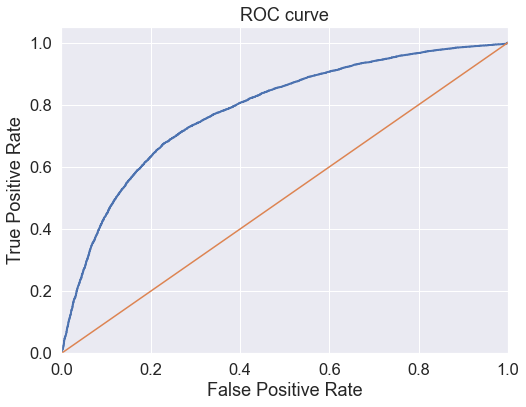

Кривая roc auc LogisticRegression


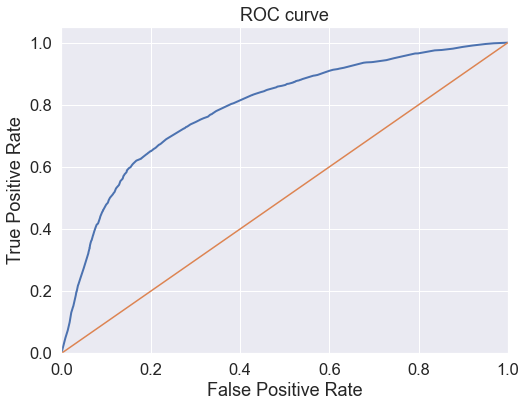

Кривая roc auc RandomForestClassifier


In [100]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

for i in list_algorim:
    classifier = algoritms(i)
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()
    print(f'Кривая roc auc {i}')

Посомтрим на матрицу ошибок

In [101]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\sanks\AppData\Local\Temp/ipykernel_12984/856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[6306 2514]
 [2363 6317]]


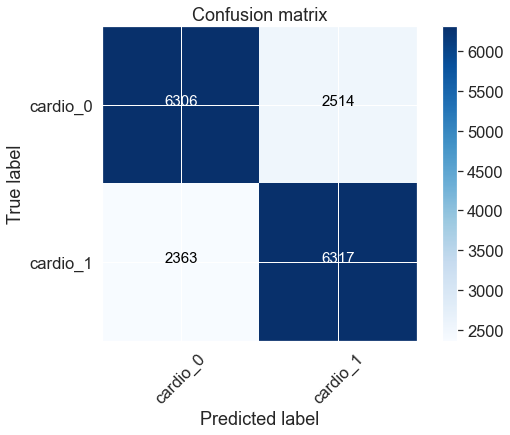

Матрица ошибок по LogisticRegression
TPR = 0.728, FPR = 0.285, TNR = 0.715 


Confusion matrix, without normalization
[[6834 1986]
 [3014 5666]]


C:\Users\sanks\AppData\Local\Temp/ipykernel_12984/856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


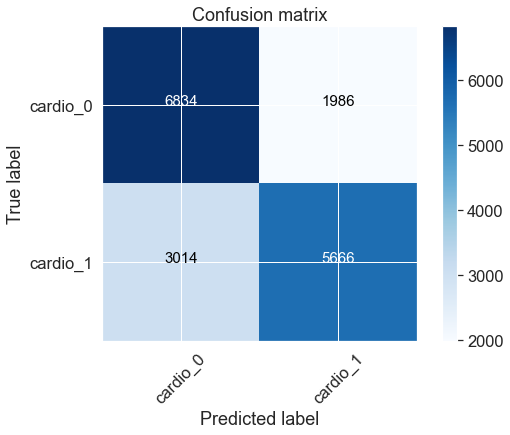

Матрица ошибок по RandomForestClassifier
TPR = 0.653, FPR = 0.225, TNR = 0.775 




In [102]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

for i in list_algorim:
    classifier = algoritms(i)
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(f'Матрица ошибок по {i}')
    print(f'TPR = {TPR:.3f}, FPR = {FPR:.3f}, TNR = {TNR:.3f}', '\n\n')

False Positive Rate у деревьев меньше чем у логрег ~ 0.23.

Это означает, что 23 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

TNR = 0.78 -> модель может автоматически фильтровать 78% наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра
TPR = 0.65 -> доля ошибочно классифицированных как с серд.-сосуд. заболевания (хотя здоровы), не будет превышать при этом 23 процента

В общем и целом различия между моделями не очень сильные, но думаю если подобрать оптимальные гиперпараметры к деревьям, то результат будет лучше.

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic